In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd
import torchvision

from PIL import Image 

import scanpy
import anndata as ad
import pandas as pd

In [2]:
nProt=6
holdOutSamples_samples=[['HV1','P22','P14','P27','HV3','P46','P24','P37'],
                        ['HV5','P68','P44','P42','HV7','P15','P55','P59'],
                        ['HV8','P47','P63','P70','HV2','P57','P72','P83'],
                        ['HV4','P16','P18','P62','HV6','P52','P41','P38'],
                        ['HV1','P84','P50','P48','HV2','P22','P56','P27'],
                        ['HV3','P46','P14','P37','HV4','P68','P44','P42'],
                        ['HV5','P15','P24','P59','HV6','P47','P55','P70'],
                        ['HV7','P57','P63','P83','HV8','P16','P18','P62'],
                        ['HV1','P52','P72','P38','HV5','P84','P41','P48'],
                        ['HV2','P22','P50','P27','HV3','P68','P24','P59'],
                        ['HV4','P47','P56','P37','HV7','P16','P44','P70'],
                        ['HV6','P46','P14','P42','HV8','P15','P55','P83']]

pnames=np.array(['gh2ax','cd8','cd16', 'cd3', 'cd4',   'lamin'])

In [3]:
sharedSizes=[1024]
dSpecific_filter=[(200,16)]
pID_type='randInit'
pIDemb_size=64

seed=3

name_lord='splitChannels_conditional_lord_withNoise_bce'
modelname_lord='cnn_vae_pbmc_lord'
logsavepath_lord=os.path.join('../../data/c2p/log/',modelname_lord,name_lord)
modelsavepath_lord=os.path.join('../../data/c2p/models/',modelname_lord,name_lord)
plotsavepath_lord=os.path.join('../../data/c2p/plots/',modelname_lord,name_lord)

logsavepath_p_dna=os.path.join(logsavepath_lord,'dna')
modelsavepath_p_dna=os.path.join(modelsavepath_lord,'dna')
plotsavepath_p_dna=os.path.join(plotsavepath_lord,'dna')

logsavepath_p_protein=os.path.join(logsavepath_lord,'protein')
modelsavepath_p_protein=os.path.join(modelsavepath_lord,'protein')
plotsavepath_p_protein=os.path.join(plotsavepath_lord,'protein')

currLatentSize=sharedSizes[0]
dSpecificSize,dfilterSize=dSpecific_filter[0]


In [53]:

    
name_train='nmcoClf_origImg'
modelname_train='resnet18'

In [54]:
import scipy.stats

In [71]:
sourceDir='../../data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)


p='gh2ax':    
c2nmco_val={}
c2nmco_heldout={}
p2nmco_val={}
p2nmco_heldout={}
for h in range(len(holdOutSamples_samples)):
    print(h)
    holdOutSamples=holdOutSamples_samples[h]

    
    plotsavepath_c2pf_p=os.path.join(plotsavepath_lord,'chromatinImg2proteinFeatures',p,str(h))
    logsavepath_c2pf_p=os.path.join(logsavepath_lord,'chromatinImg2proteinFeatures',p,str(h))
    plotsavepath_c2pf_p_protein=os.path.join(plotsavepath_lord,'proteinImg2proteinFeatures',p,str(h))
    logsavepath_c2pf_p_protein=os.path.join(logsavepath_lord,'proteinImg2proteinFeatures',p,str(h))
    
        
    
    with open(os.path.join(sourceDir,'nmco_allfeatures_names_'+p), 'rb') as output:
        nmco_names=pickle.load(output)
    
    for nmcoIdx in range(nmco_names.size):
        if nmco_names[nmcoIdx] not in ['kurtosis_gh2ax_2d_int','gh2ax_foci_count','median_gh2ax_3d_int']:
            continue
        logsavepath_train_curr=os.path.join(logsavepath_c2pf_p,modelname_train+'_'+name_train+'_'+nmco_names[nmcoIdx])
        plotsavepath_train_curr=os.path.join(plotsavepath_c2pf_p,modelname_train+'_'+name_train+'_'+nmco_names[nmcoIdx])

        logsavepath_train_curr_protein=os.path.join(logsavepath_c2pf_p_protein,modelname_train+'_'+name_train+'_'+nmco_names[nmcoIdx])
        plotsavepath_train_curr_protein=os.path.join(plotsavepath_c2pf_p_protein,modelname_train+'_'+name_train+'_'+nmco_names[nmcoIdx])

        print(p)
        print(nmco_names[nmcoIdx])

        
        resval= pd.read_csv(os.path.join(plotsavepath_train_curr,'predictions_val.csv'))
        resheldout= pd.read_csv(os.path.join(plotsavepath_train_curr,'predictions_heldout.csv'))
        resval_protein= pd.read_csv(os.path.join(plotsavepath_train_curr_protein,'predictions_val.csv'))
        resheldout_protein= pd.read_csv(os.path.join(plotsavepath_train_curr_protein,'predictions_heldout.csv'))
        
        if h==0:
            c2nmco_val[nmco_names[nmcoIdx]]=np.zeros(len(holdOutSamples_samples))
            c2nmco_heldout[nmco_names[nmcoIdx]]=np.zeros(len(holdOutSamples_samples))
            p2nmco_val[nmco_names[nmcoIdx]]=np.zeros(len(holdOutSamples_samples))
            p2nmco_heldout[nmco_names[nmcoIdx]]=np.zeros(len(holdOutSamples_samples))
        c2nmco_val[nmco_names[nmcoIdx]][h]=scipy.stats.pearsonr(resval['true'],resval['predicted'])[0]
        c2nmco_heldout[nmco_names[nmcoIdx]][h]=scipy.stats.pearsonr(resheldout['true'],resheldout['predicted'])[0]
        p2nmco_val[nmco_names[nmcoIdx]][h]=scipy.stats.pearsonr(resval_protein['true'],resval_protein['predicted'])[0]
        p2nmco_heldout[nmco_names[nmcoIdx]][h]=scipy.stats.pearsonr(resheldout_protein['true'],resheldout_protein['predicted'])[0]
            


0
gh2ax
kurtosis_gh2ax_2d_int
gh2ax
median_gh2ax_3d_int
gh2ax
gh2ax_foci_count
1
gh2ax
kurtosis_gh2ax_2d_int
gh2ax
median_gh2ax_3d_int
gh2ax
gh2ax_foci_count
2
gh2ax
kurtosis_gh2ax_2d_int
gh2ax
median_gh2ax_3d_int
gh2ax
gh2ax_foci_count
3
gh2ax
kurtosis_gh2ax_2d_int
gh2ax
median_gh2ax_3d_int
gh2ax
gh2ax_foci_count
4
gh2ax
kurtosis_gh2ax_2d_int
gh2ax
median_gh2ax_3d_int
gh2ax
gh2ax_foci_count
5
gh2ax
kurtosis_gh2ax_2d_int
gh2ax
median_gh2ax_3d_int
gh2ax
gh2ax_foci_count
6
gh2ax
kurtosis_gh2ax_2d_int
gh2ax
median_gh2ax_3d_int
gh2ax
gh2ax_foci_count
7
gh2ax
kurtosis_gh2ax_2d_int
gh2ax
median_gh2ax_3d_int
gh2ax
gh2ax_foci_count
8
gh2ax
kurtosis_gh2ax_2d_int
gh2ax
median_gh2ax_3d_int
gh2ax
gh2ax_foci_count
9
gh2ax
kurtosis_gh2ax_2d_int
gh2ax
median_gh2ax_3d_int
gh2ax
gh2ax_foci_count
10
gh2ax
kurtosis_gh2ax_2d_int
gh2ax
median_gh2ax_3d_int
gh2ax
gh2ax_foci_count
11
gh2ax
kurtosis_gh2ax_2d_int
gh2ax
median_gh2ax_3d_int
gh2ax
gh2ax_foci_count


In [73]:
c2nmco_val_df=pd.DataFrame(c2nmco_val)
p2nmco_val_df=pd.DataFrame(p2nmco_val)
c2nmco_val_df

,kurtosis_gh2ax_2d_int,median_gh2ax_3d_int,gh2ax_foci_count
0,0.697126,0.760282,0.507452
1,0.611218,0.727841,0.394106
2,0.438176,0.684883,0.503262
3,0.653987,0.895225,0.370214
4,0.696745,0.781612,0.341236
5,0.630937,0.873455,0.497436
6,0.665046,0.911580,0.573980
7,0.608931,0.748861,0.456671
8,0.536400,0.712067,0.283719
9,0.673967,0.638874,0.479236


Text(0, 0.5, "Pearson's correlation")

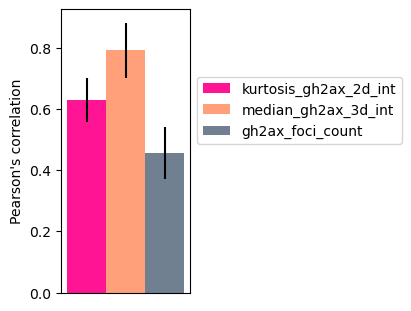

In [88]:
colors=['deeppink','lightsalmon','slategrey']
width = 0.12  
multiplier = 0
fig,ax=plt.subplots(figsize=(4,3),layout='constrained')

for tidx in range(c2nmco_val_df.shape[1]):
    t=c2nmco_val_df.columns[tidx]
    offset=width*multiplier
    bars=ax.bar(offset,np.mean(c2nmco_val_df[t],axis=0), 
               width,yerr= np.std(c2nmco_val_df[t],axis=0),label=t,color=colors[tidx])
    multiplier+=1
ax.legend(loc='lower left',bbox_to_anchor=(1, 0.5))
plt.xticks([])
plt.ylabel('Pearson\'s correlation')

In [90]:
scipy.stats.ttest_ind(c2nmco_val_df['gh2ax_foci_count'],c2nmco_val_df['kurtosis_gh2ax_2d_int'])

Ttest_indResult(statistic=-5.102024271364606, pvalue=4.116580425379373e-05)

In [91]:
scipy.stats.ttest_ind(c2nmco_val_df['gh2ax_foci_count'],c2nmco_val_df['median_gh2ax_3d_int'])

Ttest_indResult(statistic=-8.991539608658725, pvalue=8.049349177871774e-09)